In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
from os.path import join, isdir, isfile
import numpy as np
import cv2
from cselect import color as cs
from time import time
from reid import reid

from mvpose.data import umpm
from mvpose.algorithm.settings import get_settings, get_tracking_settings

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

_start = time()
X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

# --- Things that kinda have to be parametrized ---
candidate_main_name = 'umpm_ms30_candidates_frame'
dict_file = join(tmp, 'scores_s30.npy')
params = get_settings(ms_radius=30)
# -------------------------------------------------

_start = time()

#reid_model = reid.ReId()
reid_model = {}  # we can skip this ONLY if we already calc. reid scores!
tracking_params = get_tracking_settings(params, 
                                        low_spec_mode=True, 
                                        reid_model=reid_model,
                                        personreid_batchsize=2)
_end = time()
print("loading settings:", _end - _start)
def get_track(FRAMES):
    Ims = []
    Hms = []
    Pafs = []
    
    im_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'im.npy'
    hm_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'hm.npy'
    pf_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'pf.npy'
    im_name = join(tmp, im_name)
    hm_name = join(tmp, hm_name)
    pf_name = join(tmp, pf_name)
    
    if isfile(im_name) and isfile(hm_name) and isfile(pf_name):
        Ims = np.load(im_name)
        Hms = np.load(hm_name)
        Pafs = np.load(pf_name)
    else:
        for frame in FRAMES:
            print('load frame ', frame)
            Im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]])
            Ims.append(Im)
            heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
                                                                Im, 
                                                                frame, 
                                                                dir=tmp)
            Hms.append(heatmaps)
            Pafs.append(pafs)

        Ims = np.array(Ims)
        Hms = np.array(Hms)
        Pafs = np.array(Pafs)
        np.save(im_name, Ims)
        np.save(hm_name, Hms)
        np.save(pf_name, Pafs)
        
    return Ims, Hms, Pafs

X[0].shape

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
loading settings: 0.0007393360137939453


(2437, 486, 644, 3)

# Step 1: pre-load pafs and heatmaps
(my laptop 'sucks' so I need to pre-load the pafs and heatmaps)

In [2]:
# def load(FRAMES):
#     for frame in FRAMES:
#         print('handle frame ', frame)
#         Im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]])
#         heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
#                                                             Im, 
#                                                             frame, 
#                                                             dir=tmp)
#         del heatmaps
#         del pafs
#         del Im

# def qq():
#     for i in range(0, 2500, 60):
#         FRAMES = list(range(i, i+60, 30))
#         print('frames:', FRAMES)
#         _start = time()
#         load(FRAMES)
#         _end = time()
#         print('\telapsed', _end - _start)

# qq()  # "memory-efficient" way of loading the data 

# Step 2: generate candidates

In [3]:
# from mvpose import pose
# from mvpose.algorithm import graphcut

# def execute(FRAME):

#     Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

#     print('\nframe:', FRAME)
#     heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
#                                                             Im, 
#                                                             FRAME, 
#                                                             dir=tmp)
#     _start = time()
#     detections = pose.estimate_heuristic(
#         Calib, heatmaps, pafs, settings=params, 
#         debug=False, use_greedy=False)
#     _end = time()
#     print('total elapsed:', _end - _start)
    
#     # -- store to file --
#     candidate_name = candidate_main_name + str(FRAME) + ".npy"
#     candidate_name = join(tmp, candidate_name)
#     np.save(candidate_name, detections)
    
#     del heatmaps
#     del pafs
#     del detections

# def run_all():
#     # go to 2500
#     for i in range(2070, 2500, 60):
#         FRAMES = list(range(i, i+60, 30))
#         for f in FRAMES:
#             execute(f)

# run_all()



# Step 3: calculate re-id score

In [5]:
from mvpose.algorithm.track_graph_partitioning import get_bb, distance3d_humans, ValidImageCandidateExtractor
from mvpose.tracking import extend_calibration_to_frames

n_frames = 2437
graph_3d = {}
human_candidates = []
Im = []
for frame in range(0, n_frames, 30):
    if frame % 300 == 0:
        print('frame ', frame)
    candidate_name = candidate_main_name + str(frame) + ".npy"
    candidate_name = join(tmp, candidate_name)
    assert isfile(candidate_name)
    Humans = np.load(candidate_name)
    human_candidates.append(Humans)
    im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]], 'uint8')
    Im.append(im)
Im = np.array(Im, 'uint8')

print(len(human_candidates))

Calibs = extend_calibration_to_frames([Calib], n_frames)

img_cand = ValidImageCandidateExtractor(Im, human_candidates, Calibs, tracking_params)

# n = len(img_cand.ImgsA)
# start = 0
# if isfile(dict_file):
#     start = np.load(dict_file).item()['next_frame']

# print('start:' + str(start) + ' until ' + str(n))
# for frame in range(start, n):
#     if isfile(dict_file):
#         storage = np.load(dict_file).item()
#     else:
#         storage = {}
    
#     if frame % 10 == 0:
#         print('frame %05d/' % (frame+1) + str(n))
#         _start = time()
#     A = img_cand.ImgsA[frame]
#     B = img_cand.ImgsB[frame]
#     score = np.squeeze(reid_model.predict(A, B))
#     #print('storage', storage)
#     #print('score', score)
#     storage[frame] = score
#     storage['next_frame'] = frame + 1
#     np.save(dict_file, storage)
#     if frame % 10 == 0:
#         _end = time()
#         print('\telapsed', _end - _start)
#     del storage
    

frame  0
frame  300
frame  600
frame  900
frame  1200
frame  1500
frame  1800
frame  2100
frame  2400
82


# Step 4: build graph

In [6]:
from mvpose.algorithm.track_graph_partitioning import generate_graph3d, GraphSolver
from mvpose.algorithm.track_graph_partitioning import construct_query_graph
from mvpose.tracking import extract_tracks

storage = np.load(dict_file).item()

scores = []
pairs = img_cand.pairs
n = len(img_cand.ImgsA)
print(n)

assert(len(pairs) == n)
for frame in range(n):
    scores.append(storage[frame])
assert len(scores) == n


graph_3d = generate_graph3d(scores, pairs)  # t1, pid1, t2, pid2

n_frames_red = len(human_candidates)
graph_partitioning = GraphSolver(graph_3d, 
                                 n_frames_red,
                                 tracking_params.T)


G = construct_query_graph(graph_partitioning, n_frames_red)

tracks = extract_tracks(human_candidates, G)

13305
[graph partitioning]
	solve graph with 1022 edges...


# Step 5: Evaluation

In [53]:
import numpy as np
from pak.evaluation import MOTA

from mvpose.tracking import extract_tracks

tracks = extract_tracks(human_candidates, G)

# right food: own dataset: 13, mscoco: 10

Gt = []
Hy = []
for loc_frame, frame in enumerate(range(0, n_frames, 30)):
    # === ground truth ===
    y = Y[frame]
    pid1 = 0
    p1 = y[13, 0:3]
    pid2 = 1
    p2 = y[13+14, 0:3]
    Gt.append((loc_frame, pid1, *p1))
    Gt.append((loc_frame, pid2, *p2))
    
    # === hypothesis ===
    for loc, human in enumerate(human_candidates[loc_frame]):
        pt = human[10]
        pid = tracks[loc_frame][loc]
        if pt is not None:
            Hy.append((loc_frame, pid, *pt))
    
    
# print(Hy)
# print('--')
# print(Gt)
Hy = np.array(Hy)
Gt = np.array(Gt)

threshold = 100
# result is a scalar value in the range of [-infinity, 1)
mota, info, debug = MOTA.evaluate(Gt, Hy, threshold, info=True, 
                           debug_info=True)

print('MOTA', mota)
print('info', info)

MOTA 0.9451219512195121
info {'FN': 5, 'FP': 4, 'IDSW': 0, 'GT': 164}


# Plot FP


frame: 16, pid:0
	distance to pid0: 107.52535082777274
	distance to pid1: 2646.2957149239846

frame: 43, pid:0
	distance to pid0: 131.12555663256077
	distance to pid1: 838.2660129911977

frame: 58, pid:0
	distance to pid0: 104.3675219909934
	distance to pid1: 1536.8096753377417

frame: 59, pid:0
	distance to pid0: 120.12125623708911
	distance to pid1: 2535.8094018084207


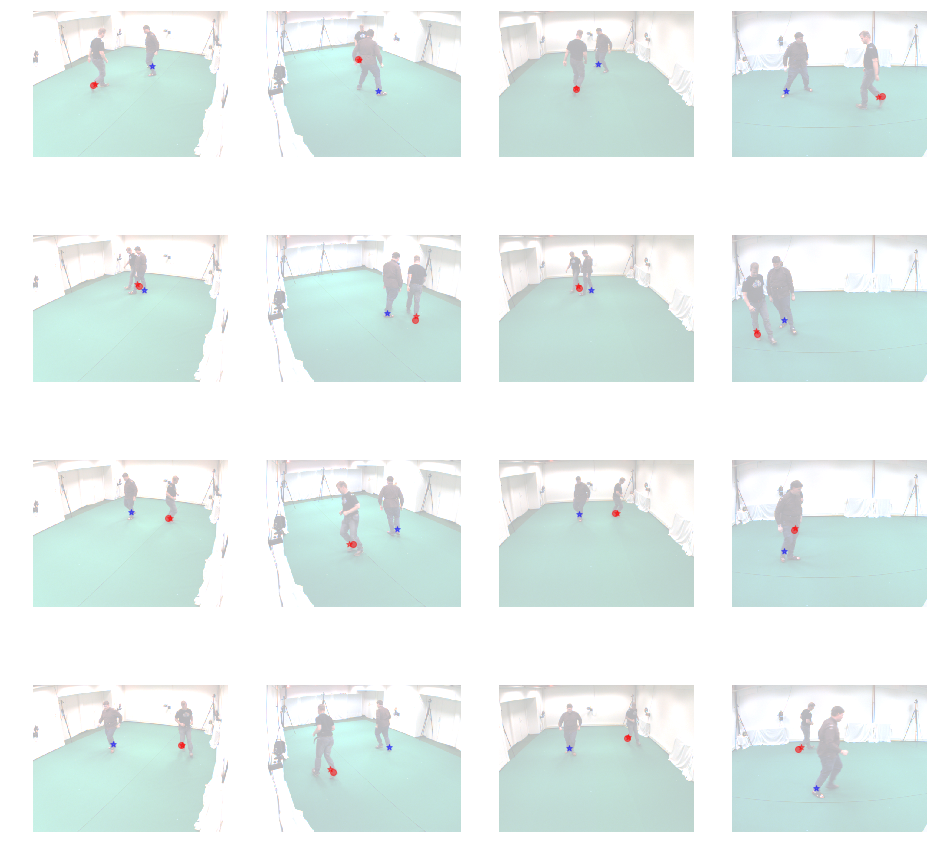

In [59]:
import numpy.linalg as la

GT_jid = 13  # 0 ... 13
HY_jid = 10  # 0 ... 17

FP_pairs = debug['FP']
n = len(FN_pairs)

colors = ['red', 'blue', 'green', 'yellow', 'lila']

fig = plt.figure(figsize=(16, 4 * n))

for idx, (frame, pid, x, y, z) in enumerate(FP_pairs):
    frame = int(frame)
    pid_hat = int(pid)
    p_est = np.array((x, y, z))
    
    # -- get real locations --
    real_frame = 30 * frame
    y = Y[real_frame]
    pid1 = 0
    p1 = y[GT_jid, 0:3]
    pid2 = 1
    p2 = y[GT_jid+14, 0:3]
    
    print('\nframe: ' + str(frame) + ', pid:' + str(pid_hat))
    print('\tdistance to pid0:', la.norm(p1 - p_est))
    print('\tdistance to pid1:', la.norm(p2 - p_est))
    
    for cid in range(1, 5):
        cam = Calib[cid-1]
        ax = fig.add_subplot(n, 4, (idx*4)+cid)
        ax.axis('off')
        ax.imshow(Im[frame][cid-1], alpha=0.3)
        
        pts2d = cam.projectPoints(np.array([p1, p2, p_est]))
        p1_2d, p2_2d, p_est_2d = pts2d
        ax.scatter(p1_2d[0], p1_2d[1], color=colors[0], marker='*', alpha=0.5)
        ax.scatter(p2_2d[0], p2_2d[1], color=colors[1], marker='*', alpha=0.5)
        ax.scatter(p_est_2d[0], p_est_2d[1], color=colors[pid_hat], marker='o', alpha=0.5)
        
    
plt.show()

# Plot to images

In [ ]:
# from mvpose.algorithm.candidate_selection import project_human_to_2d
# from mvpose.plot.limbs import draw_mscoco_human
# output_loc = '/home/julian/Videos'

# frame = 0

# for frame in range(57, n_frames_red):
#     print('handle', frame)
#     colors = ['red', 'blue', 'green']

#     fname = join(output_loc, '%04d.png' % frame)

#     fig = plt.figure(figsize=(16, 12))

#     FRAME = frame * 30
#     Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
#     TR = tracks[frame]
#     HM = human_candidates[frame]

#     for idx, cam in enumerate(Calib):
#         ax = fig.add_subplot(2,2,1+idx)
#         ax.axis('off')
#         im = Im[idx]
#         h,w,_ = im.shape
#         ax.imshow(im, alpha=0.6)

#         for pid, human in enumerate(HM):
#             draw_mscoco_human(ax, human, cam, color=colors[TR[pid]])

#     plt.savefig(fname)
#     del fig
#     del Im
#     del TR
#     del HM

In [ ]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

FRAME = 1110
candidate_name = candidate_main_name + str(FRAME) + ".npy"
candidate_name = join(tmp, candidate_name)
Humans = np.load(candidate_name)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
        
plt.show()